<a href="https://colab.research.google.com/github/adrianaleticiamartinez/MCD/blob/main/ML1_Final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Social Media Bot Detection Project

GitHub link: https://github.com/adrianaleticiamartinez/MCD/blob/main/ML1_Final_project.ipynb

## Project Metadata

- **University:** Universidad Panamericana
- **Course:** Machine Learning I
- **Team Members:**
  - David Arturo Hernández Gómez
  - Adriana Leticia Martínez Estrada
- **Date:** December 5th, 2023
- **Code Version:** 1.3

## Project Overview

### Description
The advent of social media has been accompanied by the proliferation of automated accounts or 'bots' that can significantly influence the dissemination of information. These bots can be benign, serving to automate repetitive tasks, or malicious, spreading misinformation or spam. The goal of this project is to create a supervised machine learning model that can accurately distinguish between human users and bots based on their behavior on social media platforms.

### Objectives
- To understand the patterns and characteristics that differentiate bot behavior from human behavior.
- To implement a binary classification model that can predict whether a social media account is a bot.
- To evaluate the model's performance using metrics such as AUC-ROC, precision, and sensitivity.

## Methodology

### Data Processing
We begin by sourcing data from known bot and human-operated accounts, extracting features indicative of their behavior patterns.

### Model Development
We will explore various machine learning algorithms, fine-tune our models, and validate their performance rigorously.

### Evaluation
Performance of the models will be assessed using the AUC-ROC curve, precision, recall, and f1-score metrics, ensuring a robust evaluation framework.

## Execution Instructions
Please execute all the notebook cells in sequential order. Each cell is documented to describe the processes being performed, from data preprocessing to model evaluation.

---

*For detailed analysis and discussion on the results, please refer to the subsequent sections of this notebook.*



## Implementation

In [1]:
# Necessary library imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, roc_auc_score, ConfusionMatrixDisplay

In [2]:
import warnings;
warnings.simplefilter('ignore')

In [3]:
# Global variables
DATASET_BOT_PATH = 'https://raw.githubusercontent.com/adrianaleticiamartinez/MCD/main/botwiki-2019.tsv'
DATASET_BOT_COMPLEMENT_PATH = "https://raw.githubusercontent.com/adrianaleticiamartinez/MCD/main/botwiki-2019_tweets.json"
DATASET_USER_PATH = 'https://raw.githubusercontent.com/adrianaleticiamartinez/MCD/main/verified-2019.tsv'
DATASET_USER_COMPLEMENT_PATH = 'https://raw.githubusercontent.com/adrianaleticiamartinez/MCD/main/verified-2019_tweets.json'

In [4]:
#Cleaning single field registries
def columns_analize(df, campos_unicos):
  columns_to_drop = []
  for i in df.columns:
    if len(list(df[i].value_counts())) <= campos_unicos:
      columns_to_drop.append(i)
  return columns_to_drop

In [5]:
# Main data preprocessing and analysis functions
def preprocess_data():
    """
    Preprocesses the raw data by cleaning and encoding features.

    Returns:
        X_train_preprocessed (array): Preprocessed training features.
        X_test_preprocessed (array): Preprocessed testing features.
        y_train (array): Encoded training labels.
        y_test (array): Encoded testing labels.
    """
    #--Extraction--
    print("x")

    #Reading bot information
    data_raw_bot = pd.read_csv(DATASET_BOT_PATH,sep='\t', header=0,  names=['id', 'label'])
    data_raw_bot_complement = pd.read_json(DATASET_BOT_COMPLEMENT_PATH)
    df_unpacked_bot = pd.json_normalize(data_raw_bot_complement['user'])
    joined_bot_data = pd.merge(data_raw_bot, df_unpacked_bot, on="id")
    print("x")

    #Reading user information
    data_raw_user = pd.read_csv(DATASET_USER_PATH,sep='\t', header=0,  names=['id', 'label'])
    data_raw_user_complement = pd.read_json(DATASET_USER_COMPLEMENT_PATH)
    df_unpacked_user = pd.json_normalize(data_raw_user_complement['user'])
    joined_user_data = pd.merge(data_raw_user, df_unpacked_user, on="id")

    #Full data
    frames = [joined_bot_data, joined_user_data]
    full_data = pd.concat(frames)

    #--Transformation--
    size_Data = len(full_data)
    full_data = full_data.drop(columns = ["id_str", "name"])



    unique_value_all_columns = columns_analize(full_data, 1)

    full_data = full_data.drop(columns = unique_value_all_columns)

    only_two_values_columns = columns_analize(full_data, 5)

    columns_to_drop = []
    for i in only_two_values_columns:
      percentage_same_value = [(x / size_Data) for x in list(full_data[i].value_counts())]
      for j in percentage_same_value:
        if j > 0.9:
          columns_to_drop.append(i)

    full_data = full_data.drop(columns = columns_to_drop)

    #Droping all columns that contain an URL
    columns_with_url = full_data.filter(regex='url', axis=1)

    full_data = full_data.drop(columns = columns_with_url.columns)

    #Droping all columns with color data
    columns_with_color = full_data.filter(like='color', axis=1)

    full_data = full_data.drop(columns=columns_with_color.columns)

    #Droping creation date column
    full_data = full_data.drop(columns=["created_at"])
    #Droping description column

    full_data = full_data.drop(columns=["description"])

    #Data Segmentation

    X = full_data[["location", "followers_count", "friends_count", "listed_count", "favourites_count", "geo_enabled", "verified", "statuses_count", "profile_background_tile", "profile_use_background_image", "has_extended_profile", "default_profile"]]
    y = full_data["label"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=117)

    #Pipelines
    attributes_number = Pipeline(steps = [
        ('null_replacement', SimpleImputer(strategy = 'mean')),
        ('scaling', StandardScaler())
    ])

    attributes_category = Pipeline(steps = [
        ('null_replacement', SimpleImputer(strategy = 'most_frequent')),
        ('encoding', OneHotEncoder(handle_unknown = 'ignore', sparse_output = False))
    ])

    attributes_preprocess = ColumnTransformer(transformers = [
        ('number', attributes_number, X_train.select_dtypes(include='number').columns.tolist()),
        ('category', attributes_category, X_train.select_dtypes(include='category').columns.tolist())
    ])
    label_encoding = LabelEncoder()

    y_train = label_encoding.fit_transform(y_train)
    y_train
    preprocessor = ColumnTransformer(transformers=[
        ('number', attributes_number, X_train.select_dtypes(include='number').columns.tolist()),
        ('category', attributes_category, X_train.select_dtypes(include='category').columns.tolist())
    ])
    X_train_preprocessed = preprocessor.fit_transform(X_train)
    X_test_preprocessed = preprocessor.transform(X_test)

    y_test_encoded = label_encoding.transform(y_test)

     # Aquí tú código
    # ...


    return X_train_preprocessed, X_test_preprocessed, y_train, y_test_encoded

In [6]:
def train_models(X_train_preprocessed, y_train):
    """
    Trains Ridge and Decision Tree classifiers.

    Args:
        X_train (array): Training features.
        y_train (array): Training labels.

    Returns:
        ridge_model (RidgeClassifier): Trained Ridge classifier.
        tree_model (DecisionTreeClassifier): Trained Decision Tree classifier.
    """
    #--L2 (RidgeClassifier)--

    ridge_model = RidgeClassifier()
    ridge_model.fit(X_train_preprocessed, y_train)

    #--tree_model (DecisionTreeClassifier)
    tree_model = DecisionTreeClassifier()
    tree_model.fit(X_train_preprocessed, y_train)

     # Aquí tú código
    # ...

    return ridge_model, tree_model

In [7]:
def evaluate_models(X_test_preprocessed, y_test_encoded, ridge_model, tree_model):
    """
    Evaluates the performance of the trained models.

    Args:
        X_test (array): Testing features.
        y_test (array): Testing labels.
        ridge_model (RidgeClassifier): Trained Ridge classifier.
        tree_model (DecisionTreeClassifier): Trained Decision Tree classifier.
    """
    y_pred_ridge = ridge_model.predict(X_test_preprocessed)

    y_pred_tree = tree_model.predict(X_test_preprocessed)

    print("Evaluación de RidgeClassifier:")
    print(classification_report(y_test_encoded, y_pred_ridge))
    print("AUC-ROC:", roc_auc_score(y_test_encoded, ridge_model.decision_function(X_test_preprocessed)))
    ConfusionMatrixDisplay.from_predictions(y_test_encoded, y_pred_ridge)
    plt.show()


    # Evaluación de DecisionTreeClassifier
    print("Evaluación de DecisionTreeClassifier:")
    print(classification_report(y_test_encoded, y_pred_tree))
    print("AUC-ROC:", roc_auc_score(y_test_encoded, tree_model.predict_proba(X_test_preprocessed)[:, 1]))
    ConfusionMatrixDisplay.from_predictions(y_test_encoded, y_pred_tree)
    plt.show()

    # Aquí tú código
    # ...

x
x
Evaluación de RidgeClassifier:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       209
           1       0.74      1.00      0.85       596

    accuracy                           0.74       805
   macro avg       0.37      0.50      0.43       805
weighted avg       0.55      0.74      0.63       805

AUC-ROC: 0.9713239780353874


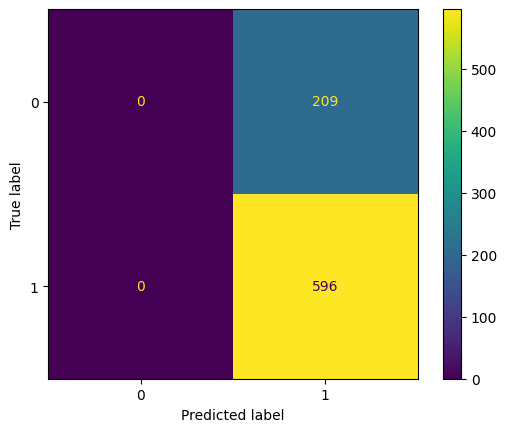

Evaluación de DecisionTreeClassifier:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       209
           1       0.98      0.98      0.98       596

    accuracy                           0.97       805
   macro avg       0.97      0.97      0.97       805
weighted avg       0.97      0.97      0.97       805

AUC-ROC: 0.9652949487813495


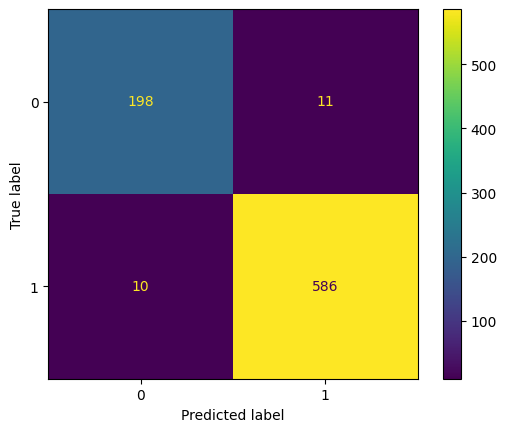

In [8]:
# Main script execution
if __name__ == "__main__":
    # Data preprocessing
    X_train_preprocessed, X_test_preprocessed, y_train, y_test_encoded = preprocess_data()

    # Model training
    ridge_model, tree_model = train_models(X_train_preprocessed, y_train)

    # Model evaluation
    evaluate_models(X_test_preprocessed, y_test_encoded, ridge_model, tree_model)